### Part 1: data pre-processing

In [2]:
# Python code to build Machine Learning model for hurricane intensity forecast  
import pandas as pd # For data manipulation and analysis
pd.set_option('display.max_columns', 500)
import numpy as np # For scientific computing

#!pip3 install sklearn # Install machine learning library
import sklearn # For machine learning library
from sklearn.ensemble import RandomForestClassifier  # Random forest classifier
#from sklearn.ensemble import ExtraTreesClassifier    # Extra tree classifier
from sklearn.metrics import confusion_matrix # Compute confusion matrix to evaluate the accuracy of a classification.
from sklearn.metrics import brier_score_loss  # Compute the Brier score

import matplotlib.pyplot as plt  #plotting library
from global_land_mask import globe # a library to check whether a lat&lon on sea or land

##### 1.1 Eco Loss data

In [3]:
# Gathered online, didn't download the dataset but copied it
# http://www.icatdamageestimator.com/commonsearch?search=2002&x=0&y=0 
# Searched Each Year and Copied the Data into CSV

fname='https://raw.githubusercontent.com/akshaym2497/RMDS_Hurricane_Forecasting/master/data/Hurricane_Ecoloss_rawdata_Wanying.csv'

# Read EcoLoss data
Ecoloss = pd.read_csv(fname)

Ecoloss

,storm name,landfall date,damage ranke,current damage($ 2020),base damage,landfall state,category,winds(MPH)
0,Gustav,"Sep 10,2002",247,0.0,100000.0,NC,TS,65
1,Florence,"Sep 09,1988",244,2000000.0,2920000.0,LA,1,80
2,Dean,"Jul 30,1995",245,2000000.0,500000.0,TX,TS,45
3,Chris,"Sep 11,1982",242,3000000.0,2000000.0,LA,TS,65
4,Bonnie,"Jun 26,1986",239,7000000.0,2000000.0,TX,1,85
...,...,...,...,...,...,...,...,...
155,Jerry,"Aug 23,1995",189,150000000.0,40600000.0,FL,TS,40
156,Emily,"Aug 31,1993",191,130000000.0,35000000.0,NC,3,115
157,Arlene,"Jun 20,1993",211,60000000.0,22000000.0,TX,TS,40
158,Allison,"Jun 05,1995",240,7000000.0,1700000.0,FL,TS,70


In [4]:
# Extract month from landfall date
Ecoloss['MONTH'] = Ecoloss['landfall date'].apply(lambda x: str(x)[0:3])

# Extract date from landfall date
Ecoloss['DATE'] = Ecoloss['landfall date'].apply(lambda x: str(x)[4:6])

# Extract year from landfall date
Ecoloss['YEAR'] = Ecoloss['landfall date'].apply(lambda x: str(x)[7:11])

Ecoloss.sort_values("YEAR",inplace=True)

Ecoloss.head()

,storm name,landfall date,damage ranke,current damage($ 2020),base damage,landfall state,category,winds(MPH),MONTH,DATE,YEAR
70,Storm 8 in 1906,"Oct 18,1906",97,2.140000e+09,200000.0,FL,3,120,Oct,18,1906
71,Valasco,"Jul 21,1909",96,2.210000e+09,2000000.0,TX,3,115,Jul,21,1909
44,Storm 3 in 1911,"Aug 28,1911",155,4.200000e+08,1000000.0,SC,2,100,Aug,28,1911
113,Galveston,"Aug 17,1915",5,1.210000e+11,50000000.0,TX,4,130,Aug,17,1915
45,Storm 1 in 1918,"Aug 06,1918",154,4.200000e+08,5000000.0,LA,3,120,Aug,06,1918


In [5]:
Month2Int={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
Ecoloss['MONTHINT']=Ecoloss['MONTH'].apply(lambda x: Month2Int[x])
Ecoloss.head()

,storm name,landfall date,damage ranke,current damage($ 2020),base damage,landfall state,category,winds(MPH),MONTH,DATE,YEAR,MONTHINT
70,Storm 8 in 1906,"Oct 18,1906",97,2.140000e+09,200000.0,FL,3,120,Oct,18,1906,10
71,Valasco,"Jul 21,1909",96,2.210000e+09,2000000.0,TX,3,115,Jul,21,1909,07
44,Storm 3 in 1911,"Aug 28,1911",155,4.200000e+08,1000000.0,SC,2,100,Aug,28,1911,08
113,Galveston,"Aug 17,1915",5,1.210000e+11,50000000.0,TX,4,130,Aug,17,1915,08
45,Storm 1 in 1918,"Aug 06,1918",154,4.200000e+08,5000000.0,LA,3,120,Aug,06,1918,08


In [6]:
## Selecting Relevant Years in case year search serached for other column values

Ecoloss=Ecoloss[(Ecoloss['YEAR']>='1982') & (Ecoloss['YEAR']<='2017')]


In [7]:
# Ecoloss.to_csv(r'https://raw.githubusercontent.com/akshaym2497/RMDS_Hurricane_Forecasting/master/data/Ecoloss_from1982_Wanying.csv')

In [8]:
Ecoloss.YEAR.value_counts().sort_index()

1982    3
1983    1
1984    3
1985    9
1986    3
1987    2
1988    6
1989    5
1990    1
1991    1
1992    3
1993    3
1994    3
1995    7
1996    4
1997    1
1998    7
1999    5
2000    2
2001    3
2002    6
2003    3
2004    7
2005    6
2006    1
2007    1
2008    5
2010    4
2011    1
2012    2
2014    1
2016    2
2017    3
Name: YEAR, dtype: int64

In [9]:
Ecoloss=Ecoloss.reset_index(drop=True)

In [10]:
# set a 'key' to match ships dataset
# upper Name[0:4]+Year+Month(int)
Ecoloss['KEY']=0
for i in range(0,Ecoloss.shape[0]):
    Ecoloss.loc[i,'KEY']='-'.join([Ecoloss.loc[i,'storm name'][0:4].upper(),Ecoloss.loc[i,'YEAR']])
Ecoloss.head()

Ecoloss.drop_duplicates(subset=['KEY'])

,storm name,landfall date,damage ranke,current damage($ 2020),base damage,landfall state,category,winds(MPH),MONTH,DATE,YEAR,MONTHINT,KEY
0,Chris,"Sep 11,1982",242,3.000000e+06,2.000000e+06,LA,TS,65,Sep,11,1982,09,CHRI-1982
2,Subtrop 1 1982,"Jun 18,1982",204,8.400000e+07,1.000000e+07,FL,TS,45,Jun,18,1982,06,SUBT-1982
3,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,ALIC-1983
4,Isidore,"Sep 27,1984",235,8.000000e+06,1.000000e+06,FL,TS,60,Sep,27,1984,09,ISID-1984
5,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,DIAN-1984
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,Hermine,"Sep 02,2016",146,6.100000e+08,5.500000e+08,FL,1,80,Sep,02,2016,09,HERM-2016
110,Matthew,"Oct 08,2016",44,1.126000e+10,1.000000e+10,SC,2,100,Oct,08,2016,10,MATT-2016
111,Nate,"Oct 08,2017",176,2.300000e+08,2.250000e+08,MS,1,75,Oct,08,2017,10,NATE-2017
112,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,HARV-2017


In [11]:
Ecoloss.shape[0]

114

##### 1.2 Ships data

In [12]:
#====================================
#Read SHIPS spread-sheet data
#====================================
# Set up the location of the SHIPS data

## Pre-cleaned SHIPS Dataset

fname='https://raw.githubusercontent.com/akshaym2497/RMDS_Hurricane_Forecasting/master/data/SHIPS_RII_fcst_ATL_Alicia_from1982%20_Wanying.csv'
#fname='Dataset_SHIPS_RII_EPAC.csv'

# Read SHIPS data
ships = pd.read_csv(fname)
ships

,NAME,DATE,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST
0,ALBE,820602,12,20,21.7,-87.1,1005,AL011982,10,30,45,25,9999,26.4,64,70,9999,9999.0,-103,0,113,9999,25.1,29.6,49,22.4,5.1,1.6,61.8,28.0
1,ALBE,820602,18,25,22.2,-86.5,1004,AL011982,15,50,30,15,9999,19.4,65,68,9999,9999.0,-97,0,178,9999,21.6,30.2,45,18.7,4.8,2.0,61.9,28.0
2,ALBE,820603,0,30,22.6,-85.8,1003,AL011982,20,35,15,0,10,19.3,84,70,9999,9999.0,-87,0,116,9999,18.6,29.8,75,16.9,5.2,1.8,61.0,27.8
3,ALBE,820603,6,40,22.8,-85.0,1001,AL011982,35,15,0,-15,15,17.7,70,70,9999,9999.0,-75,0,439,9999,22.1,36.2,88,17.9,4.8,1.8,60.3,27.6
4,ALBE,820603,12,50,23.2,-84.2,995,AL011982,15,-5,-20,-25,20,17.4,51,66,9999,9999.0,-71,0,758,9999,24.3,34.0,60,20.9,2.2,2.2,61.5,27.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11777,RINA,171108,0,45,34.6,-48.7,999,AL192017,0,0,9999,9999,5,20.5,29,71,31,24.3,-37,0,1000,123,25.2,33.1,36,22.0,1.3,5.0,42.9,23.5
11778,RINA,171108,6,50,36.4,-48.7,996,AL192017,-5,9999,9999,9999,10,20.8,19,73,15,14.7,-28,0,969,90,24.5,32.3,16,21.8,1.1,5.4,43.0,22.9
11779,RINA,171108,12,45,38.3,-48.8,994,AL192017,0,9999,9999,9999,0,21.2,12,74,9,13.5,-29,0,966,126,25.2,33.8,3,23.0,0.0,6.7,43.0,22.7
11780,RINA,171108,18,45,40.1,-49.0,992,AL192017,9999,9999,9999,9999,-5,22.5,14,70,7,11.5,-14,0,948,75,29.1,38.9,20,28.4,0.0,9.8,44.3,21.3


In [13]:
#================================
# Set up parameters
#================================
# Year range for training and validating
#year_train=['1998','2008']

# Year range for forecast
#year_fcst=['2009','2014']

# Variable names for predictors
#PredictorName=['PER','SHRD','D200','TPW','PC2','SDBT','POT','OHC','VMX0']

# Variable name for predictand
TargetName='DELV24'

# Threshold of Rapid Intensification 
RIValue=30

# Climatology of RI (30 kt) frequency at Atlantic basin (Kaplan et al. 2015)
clim=0.125   #ATL 30 kt
#clim=0.084   #EPAC 30 kt

In [14]:
#================================
# Data pre-processing
#================================
# Set all 9999s as NaNs
ships = ships.replace(9999,np.NaN)

# drop NaNs
ships=ships.dropna()

ships['DATEs'] = ships['DATE'].apply(lambda x: str(x).zfill(6))
ships['DATEs'] = ships['DATEs'].apply(lambda x: ('19' + str(x)[0:2] + str(x)[2:]) if (str(x)[0:1]!= '0' and str(x)[0:1]!= '1') else ('20' + str(x)[0:2] + str(x)[2:]))
 

# Pad the date columns with 00 for the year 2000
ships['DATE'] = ships['DATE'].apply(lambda x: str(x).zfill(6))

# Extract month from date
ships['MONTH'] = ships['DATE'].apply(lambda x: str(x)[2:4])

# Extract year from date
ships['YEAR'] = ships['DATE'].apply(lambda x: ('19' + str(x)[0:2]) if (str(x)[0:1]!= '0' and str(x)[0:1]!= '1') else ('20' + str(x)[0:2]))

# Extract day from date
ships['DAY'] = ships['DATE'].apply(lambda x: str(x)[4:6])

# Set the target column
ships['TAR'] = ships[TargetName].apply(lambda x: 1 if x >= RIValue else 0)
ships.head()



ships['DATETIME'] = ships['DATEs'] + ' '+ ships['HOUR'].astype(str)
ships['DATETIME'] = pd.to_datetime(ships['DATETIME'], format = '%Y%M%d %H')

In [15]:
ships=ships.reset_index(drop=True)
# set a 'key' to match ships dataset
# upper Name[0:4]+Year+Month(int)
ships['KEY']=0
for i in range(0,ships.shape[0]):
    ships.loc[i,'KEY']='-'.join([ships.loc[i,'NAME'],ships.loc[i,'YEAR']])
ships.head()

,NAME,DATE,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH,YEAR,DAY,TAR,DATETIME,KEY
0,DEBB,820914,0,30,21.5,-71.0,1009.0,AL061982,5.0,35.0,45.0,65.0,0.0,16.9,26,65,49.0,28.6,-110,0,126,35.0,17.0,20.8,30.0,5.6,5.4,2.4,58.5,28.8,19820914,09,1982,14,1,1982-01-14 00:09:00,DEBB-1982
1,DEBB,820914,6,30,22.4,-71.8,1008.0,AL061982,25.0,35.0,60.0,65.0,0.0,20.7,23,67,47.0,28.4,-112,0,591,23.0,18.8,23.5,18.0,8.7,4.6,2.5,58.3,28.7,19820914,09,1982,14,1,1982-01-14 06:09:00,DEBB-1982
2,DEBB,820914,12,35,23.5,-71.9,1006.0,AL061982,30.0,40.0,60.0,60.0,5.0,8.7,40,66,49.0,30.0,-110,0,640,31.0,14.2,18.1,64.0,7.2,4.5,2.5,57.2,28.8,19820914,09,1982,14,1,1982-01-14 12:09:00,DEBB-1982
3,DEBB,820914,18,55,24.6,-71.8,1000.0,AL061982,10.0,35.0,40.0,40.0,25.0,13.3,39,64,74.0,19.6,-82,0,166,-60.0,11.2,16.9,46.0,8.2,5.9,2.6,58.6,28.8,19820914,09,1982,14,1,1982-01-14 18:09:00,DEBB-1982
4,DEBB,820915,0,65,25.6,-71.0,993.0,AL061982,10.0,30.0,30.0,30.0,30.0,17.9,53,62,87.0,10.7,-74,0,479,-83.0,16.2,24.4,71.0,13.0,6.0,2.5,59.3,28.9,19820915,09,1982,15,1,1982-01-15 00:09:00,DEBB-1982


In [16]:
## Verifying for duplicate Key

# for name in ships['NAME'].unique():
#     ships_name=ships[ships['NAME']==name]
#     for year in ships_name['YEAR']:
#         ships_name_year=ships_name[ships_name['YEAR']==year]
#         dub_count=len(ships_name_year['ID'].unique())
#         if dub_count>1:
#             print('%s'%name)
        
        


In [17]:
# combine two tables
Merge = pd.merge(ships, Ecoloss, on=['KEY'])
Merge

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,landfall state,category,winds(MPH),MONTH_y,DATE_y,YEAR_y,MONTHINT
0,ALIC,830816,0,45,27.1,-91.5,1005.0,AL031983,10.0,20.0,30.0,50.0,15.0,10.4,-28,56,43.0,18.9,-104,0,630,72.0,8.3,13.0,-51.0,-3.4,6.2,3.9,53.8,30.0,19830816,08,1983,16,0,1983-01-16 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08
1,ALIC,830816,6,50,27.0,-92.0,1004.0,AL031983,10.0,20.0,40.0,50.0,10.0,18.8,-26,56,37.0,27.4,-109,0,471,101.0,16.3,17.1,-39.0,-3.5,3.9,3.9,53.5,30.0,19830816,08,1983,16,0,1983-01-16 06:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08
2,ALIC,830816,12,55,27.1,-92.4,1002.0,AL031983,10.0,20.0,40.0,25.0,10.0,11.5,0,61,69.0,17.8,-104,0,230,-23.0,15.2,17.5,-29.0,-5.4,4.0,3.6,56.7,29.9,19830816,08,1983,16,0,1983-01-16 12:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08
3,ALIC,830816,18,60,27.3,-92.8,998.0,AL031983,10.0,30.0,40.0,-20.0,10.0,9.3,14,61,75.0,11.4,-88,0,240,-26.0,9.6,15.3,-16.0,-3.4,5.9,4.4,56.3,29.8,19830816,08,1983,16,1,1983-01-16 18:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08
4,ALIC,830817,0,65,27.4,-93.3,991.0,AL031983,10.0,30.0,15.0,-30.0,10.0,12.0,-18,57,51.0,14.7,-82,0,300,26.0,11.2,17.0,-29.0,2.5,5.9,5.0,56.3,29.9,19830817,08,1983,17,1,1983-01-17 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1851,IRMA,170910,0,100,23.4,-80.9,932.0,AL112017,15.0,-20.0,-50.0,-65.0,-10.0,8.2,111,70,97.0,6.8,-52,0,0,-135.0,11.5,15.7,116.0,0.1,5.9,2.0,68.5,30.1,20170910,09,2017,10,0,2017-01-10 00:09:00,IRMA-2017,Irma,"Sep 10,2017",12,5.297000e+10,5.000000e+10,FL,4,130,Sep,10,2017,09
1852,NATE,171005,0,30,12.6,-82.7,1004.0,AL162017,5.0,5.0,10.0,25.0,5.0,8.2,142,84,66.0,17.6,-141,0,0,-41.0,2.0,13.3,151.0,3.7,4.4,1.8,64.3,30.5,20171005,10,2017,05,0,2017-01-05 00:10:00,NATE-2017,Nate,"Oct 08,2017",176,2.300000e+08,2.250000e+08,MS,1,75,Oct,08,2017,10
1853,NATE,171005,6,35,13.1,-83.1,1001.0,AL162017,0.0,5.0,10.0,35.0,5.0,6.3,160,86,54.0,26.4,-137,0,0,-48.0,2.9,15.3,169.0,6.2,4.0,1.8,64.8,30.4,20171005,10,2017,05,0,2017-01-05 06:10:00,NATE-2017,Nate,"Oct 08,2017",176,2.300000e+08,2.250000e+08,MS,1,75,Oct,08,2017,10
1854,NATE,171005,12,35,13.9,-83.5,999.0,AL162017,0.0,5.0,20.0,45.0,5.0,10.6,160,85,56.0,14.7,-136,0,0,-82.0,6.1,15.5,182.0,8.6,3.5,1.9,65.5,30.3,20171005,10,2017,05,0,2017-01-05 12:10:00,NATE-2017,Nate,"Oct 08,2017",176,2.300000e+08,2.250000e+08,MS,1,75,Oct,08,2017,10


In [18]:
### I am not too sure about this steps

Merge1=Merge.copy()
Merge1['intDay']=Merge1['DAY'].apply(lambda x: int(x))
Merge1['intDate']=Merge1['DATE_y'].apply(lambda x: int(x))
Merge2=Merge1[Merge1['intDay']==Merge1['intDate']]
Merge2.head(30)

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,landfall state,category,winds(MPH),MONTH_y,DATE_y,YEAR_y,MONTHINT,intDay,intDate
8,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18
29,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13
30,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13
31,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13
32,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13
44,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,19850902,09,1985,02,0,1985-01-02 00:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2
45,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,19850902,09,1985,02,0,1985-01-02 12:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2
112,KATE,851121,0,105,26.8,-86.5,954.0,AL131985,-10.0,-25.0,-55.0,-65.0,0.0,18.7,66,75,92.0,10.0,15,0,0,-101.0,22.8,31.6,60.0,-1.3,0.0,5.2,58.1,25.7,19851121,11,1985,21,0,1985-01-21 00:11:00,KATE-1985,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21
113,KATE,851121,6,100,27.5,-86.6,961.0,AL131985,-15.0,-35.0,-55.0,-65.0,-5.0,12.8,110,69,88.0,12.9,17,0,236,-94.0,23.6,34.8,108.0,3.0,0.0,10.8,56.3,25.3,19851121,11,1985,21,0,1985-01-21 06:11:00,KATE-1985,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21
114,KATE,851121,12,95,28.3,-86.5,965.0,AL131985,-15.0,-45.0,-55.0,-60.0,-10.0,15.9,93,69,91.0,12.1,18,0,553,-100.0,24.6,37.1,97.0,9.3,0.0,14.6,55.8,24.7,19851121,11,1985,21,0,1985-01-21 12:11:00,KATE-1985,Kate,"Nov 21,1985",108,1.800000e+09,3.000000e+08,FL,2,100,Nov,21,1985,11,21,21


In [19]:
Merge2.YEAR_y.value_counts().sort_index()

1983     1
1984     4
1985     5
1986     4
1988    10
1989     1
1992     8
1993     3
1994    10
1995    14
1996     8
1997     4
1998    11
1999     8
2001     4
2002     2
2003     4
2004    11
2005    10
2006     2
2008     9
2010    12
2012     4
2017     5
Name: YEAR_y, dtype: int64

In [22]:
len(Merge2['ID'].unique())

47

##### 1.3 population dataset

In [77]:
## Didn't use this dataset to build the model since this is state-level population data

fname='https://raw.githubusercontent.com/akshaym2497/RMDS_Hurricane_Forecasting/master/data/population_stateLevel_Wanying.csv'

# Read Population data
population = pd.read_csv(fname)
population.head()

,NAME,State,y1998,y1999,y2000,y2001,y2002,y2003,y2004,y2005,y2006,y2007,y2008,y2009,y2010,y2011,y2012,y2013,y2014,y2015,y2016,y2017,y2018,y2019
0,Alabama,AL,4404701,4430141,4452173,4467634,4480089,4503491,4530729,4569805,4628981,4672840,4718206,4757938,4785437,4799069,4815588,4830081,4841799,4852347,4863525,4874486,4887681,4903185
1,Alaska,AK,619932,624779,627963,633714,642337,648414,659286,666946,675302,680300,687455,698895,713910,722128,730443,737068,736283,737498,741456,739700,735139,731545
2,Arizona,AZ,4883342,5023823,5160586,5273477,5396255,5510364,5652404,5839077,6029141,6167681,6280362,6343154,6407172,6472643,6554978,6632764,6730413,6829676,6941072,7044008,7158024,7278717
3,Arkansas,AR,2626289,2651860,2678588,2691571,2705927,2724816,2749686,2781097,2821761,2848650,2874554,2896843,2921964,2940667,2952164,2959400,2967392,2978048,2989918,3001345,3009733,3017804
4,California,CA,32987675,33499204,33987977,34479458,34871843,35253159,35574576,35827943,36021202,36250311,36604337,36961229,37319502,37638369,37948800,38260787,38596972,38918045,39167117,39358497,39461588,39512223


In [78]:
population.shape[0]

52

In [79]:
# row to col
State=population['State']
Year=range(1998,2020)
popu=pd.DataFrame(columns=('State', 'Year', 'population'))
for i in range(0,52):
    stateCur=State[i]
    for j in range(0,22):
        yearCur=str(Year[j])
        col='y'+yearCur
        popu = popu.append([{'State':stateCur,'Year':yearCur,'population':population.loc[i,col]}], ignore_index=True)
popu.head()

,State,Year,population
0,AL,1998,4404701
1,AL,1999,4430141
2,AL,2000,4452173
3,AL,2001,4467634
4,AL,2002,4480089


##### 1.4 GDP

In [80]:
## Didn't use this dataset to build the model since this is state-level GDP data

fname='https://raw.githubusercontent.com/akshaym2497/RMDS_Hurricane_Forecasting/master/data/GDP_stateLevel_Wanying.csv'

# Read GDP data
GDP = pd.read_csv(fname)
GDP.head()

,GeoName,State,Description,Unit,y1998,y1999,y2000,y2001,y2002,y2003,y2004,y2005,y2006,y2007,y2008,y2009,y2010,y2011,y2012,y2013,y2014,y2015,y2016,y2017,y2018,y2019
0,Alabama,AL,Real GDP (millions of chained 2012 dollars),Millions of chained 2012 dollars,149613.2,155171.9,157697.7,157137.9,161258.0,165250.5,175916.8,181871.0,185337.0,186499.4,185280.6,178893.4,183014.5,185666.9,186553.9,188814.2,187568.0,189428.8,191523.4,193693.0,198053.7,200829.4
1,Alaska,AK,Real GDP (millions of chained 2012 dollars),Millions of chained 2012 dollars,41238.4,40788.2,39566.8,41019.8,42915.8,42132.7,43752.3,45064.7,48538.5,51144.0,50891.0,55910.6,54219.0,54722.6,57717.5,54748.1,53480.6,54015.3,53289.0,52825.9,52928.7,53255.2
2,Arizona,AZ,Real GDP (millions of chained 2012 dollars),Millions of chained 2012 dollars,182983.5,198002.1,207774.8,212648.3,219370.4,233339.1,243192.6,263047.3,277189.0,284811.7,277357.6,254906.9,257396.9,263144.1,268068.2,269967.4,274112.9,281935.6,291259.6,302117.8,314016.1,323597.6
3,Arkansas,AR,Real GDP (millions of chained 2012 dollars),Millions of chained 2012 dollars,84791.3,89339.5,90224.2,90081.0,92989.3,96714.2,101194.5,104758.6,107084.1,106272.5,105923.2,102513.5,105223.6,107320.6,107718.8,110301.4,111729.9,112938.9,113490.4,114950.7,116698.8,117447.1
4,California,CA,Real GDP (millions of chained 2012 dollars),Millions of chained 2012 dollars,1470543.0,1583231.3,1709490.6,1707064.7,1747199.5,1829296.5,1902550.4,1988736.5,2072274.1,2103014.8,2110596.1,2025633.2,2056990.4,2090836.8,2144089.6,2219610.5,2316331.2,2437366.9,2519133.6,2628314.6,2708966.9,2800505.4


In [81]:
GDP.shape[0]

51

In [82]:
# row to col
State=GDP['State']
Year=range(1998,2020)
gdp=pd.DataFrame(columns=('State', 'Year', 'GDP'))
for i in range(0,51):
    stateCur=State[i]
    for j in range(0,22):
        yearCur=str(Year[j])
        col='y'+yearCur
        gdp = gdp.append([{'State':stateCur,'Year':yearCur,'GDP':GDP.loc[i,col]}], ignore_index=True)
gdp.head()

,State,Year,GDP
0,AL,1998,149613.2
1,AL,1999,155171.9
2,AL,2000,157697.7
3,AL,2001,157137.9
4,AL,2002,161258.0


### 1.5 Merge

In [83]:
## Merge2 = SHIPS + Economic Loss Data

Merge2=Merge2.rename(columns={'landfall state':'State','YEAR_y':'Year'})
Merge2

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate
8,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18
29,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13
30,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13
31,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13
32,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1802,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,20170825,08,2017,25,1,2017-01-25 00:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25
1803,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,20170825,08,2017,25,0,2017-01-25 06:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25
1804,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,20170825,08,2017,25,0,2017-01-25 12:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25
1805,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,20170825,08,2017,25,0,2017-01-25 18:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25


In [84]:
# combine two tables
## Adding state-level GDP to the dataset
Merge3 = pd.merge(Merge2,gdp,how='left',on=['State','Year'])
Merge3.head()

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN
2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN
3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN
4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN


In [85]:
# combine two tables
## Adding state-level population to the dataset

Merge4 = pd.merge(Merge3,popu,how='left',on=['State','Year'])
Merge4

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN,NaN
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN
2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN
3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN
4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,20170825,08,2017,25,1,2017-01-25 00:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273
150,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,20170825,08,2017,25,0,2017-01-25 06:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273
151,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,20170825,08,2017,25,0,2017-01-25 12:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273
152,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,20170825,08,2017,25,0,2017-01-25 18:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273


### 1.6 Match grid-GDP(lat&lon level GDP) dataset

##### 1.6.1 read data

In [86]:
## LATLONG GDP Data FROM Yale

# use grid econ data created by Yale University
fname='https://raw.githubusercontent.com/akshaym2497/RMDS_Hurricane_Forecasting/master/data/USA_econData_latLonLevel_Wanying.csv'

# Read EcoLoss data
gridGDP = pd.read_csv(fname)
gridGDP.sort_values('lat').head(60)

,lat,longitude,cellid,country,newcountryid,popgpw_1990_27_rswb,popgpw_1995_27_rswb,popgpw_2000_27_rswb,popgpw_2005_211_rswb,GDPMER90,GDPMER95,GDPMER00,GDPMER05,GDPPPP90,GDPPPP95,GDPPPP00,GDPPPP05
0,18,-156,17844,United States,840,1.796783e+02,2.061869e+02,2.314562e+02,2.492896e+02,0.004709,0.005004,0.005896,0.007603,0.004709,0.005004,0.005896,0.007603
1,19,-157,18843,United States,840,1.981229e+03,2.424067e+03,2.902888e+03,3.126819e+03,0.051923,0.058826,0.073942,0.095359,0.051923,0.058826,0.073942,0.095359
2,19,-156,18844,United States,840,1.002581e+05,1.109609e+05,1.209425e+05,1.302614e+05,2.627496,2.692736,3.080648,3.972616,2.627496,2.692736,3.080648,3.972616
3,19,-155,18845,United States,840,6.712525e+03,8.332463e+03,1.017833e+04,1.096183e+04,0.175917,0.202207,0.259263,0.334306,0.175917,0.202207,0.259263,0.334306
4,20,-158,19842,United States,840,2.682194e+02,3.119679e+02,3.547890e+02,3.821110e+02,0.008220,0.009034,0.011086,0.016203,0.008220,0.009034,0.011086,0.016203
5,20,-157,19843,United States,840,9.270767e+04,1.058429e+05,1.190861e+05,1.282588e+05,2.841233,3.064908,3.721094,5.438577,2.841233,3.064908,3.721094,5.438577
6,20,-156,19844,United States,840,1.042983e+04,1.194095e+04,1.344791e+04,1.448409e+04,0.274750,0.291368,0.344655,0.446162,0.274750,0.291368,0.344655,0.446162
7,21,-161,20839,United States,840,2.361131e+02,1.949081e+02,1.577779e+02,1.694111e+02,0.006947,0.005593,0.004519,0.005627,0.006947,0.005593,0.004519,0.005627
8,21,-160,20840,United States,840,2.039054e+04,2.152944e+04,2.228403e+04,2.399974e+04,0.599926,0.617827,0.638196,0.797164,0.599926,0.617827,0.638196,0.797164
9,21,-159,20841,United States,840,1.939011e+05,2.083950e+05,2.292059e+05,2.468665e+05,7.279771,7.442881,8.280501,10.313609,7.279771,7.442881,8.280501,10.313609


##### 1.6.2 Match Lon,Lat and Year

In [87]:
# round Lon and Lat in 'Merge4'
Merge4['LatInt']=Merge4['LAT'].apply(lambda x:round(x))
Merge4['LonInt']=Merge4['LON'].apply(lambda x:round(x))
Merge4

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN,NaN,28,-95
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77
2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77
3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78
4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,20170825,08,2017,25,1,2017-01-25 00:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,25,-94
150,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,20170825,08,2017,25,0,2017-01-25 06:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-95
151,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,20170825,08,2017,25,0,2017-01-25 12:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-96
152,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,20170825,08,2017,25,0,2017-01-25 18:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,27,-96


In [88]:
# match LON and LAT
for i in range(len(Merge4)):
    # Lat
    x0=Merge4.loc[i,'LAT']
    x1=Merge4.loc[i,'LatInt']
    x2=x1-1
    x3=x1+1
    x=[x1,x2,x3]
    # lon all are negative values
    y0=Merge4.loc[i,'LON']
    y1seires=gridGDP['longitude'][gridGDP['lat']==x1]
    y1=y1seires[abs(y1seires-y0).idxmin()] if len(y1seires)!=0 else [0] ### replace np.argmin by idxmin
    y2seires=gridGDP['longitude'][gridGDP['lat']==x2]
    y2=y2seires[abs(y2seires-y0).idxmin()] if len(y2seires)!=0 else [0] ### replace np.argmin by idxmin
    y3seires=gridGDP['longitude'][gridGDP['lat']==x3]
    y3=y3seires[abs(y3seires-y0).idxmin()] if len(y3seires)!=0 else [0] ### replace np.argmin by idxmin
    y=[y1,y2,y3]
    import math
    dist=[0,0,0]
    for j in range(0,3):
        dist[j]=math.sqrt((x[j]-x0)**2+(y[j]-y0)**2)
    index_min=dist.index(min(dist)) ### replace np.argmin by (list).index
    #print(i,x[index_min],y[index_min])
    Merge4.loc[i,'grid_Lat']=x[index_min]
    Merge4.loc[i,'grid_Lon']=y[index_min]
Merge4

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN,NaN,28,-95,29.0,-95.0
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77,34.0,-77.0
2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77,34.0,-77.0
3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78,34.0,-78.0
4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78,34.0,-78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,20170825,08,2017,25,1,2017-01-25 00:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,25,-94,25.0,-98.0
150,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,20170825,08,2017,25,0,2017-01-25 06:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-95,27.0,-97.0
151,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,20170825,08,2017,25,0,2017-01-25 12:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-96,27.0,-97.0
152,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,20170825,08,2017,25,0,2017-01-25 18:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,27,-96,27.0,-97.0


In [89]:
Merge4['Year']=Merge4['Year'].apply(lambda x:int(x))

In [90]:
# match years
## Since Yale dataset has four years of data, using those four for adjacent years
## Problem: for hurricane in 2017, it would still use Yale data from 2005.

y90=[1988,1989,1990,1991,1992]
y95=[1993,1994,1995,1996,1997]
y00=[1998,1999,2000,2001,2002]
y05=[2003,2004,2005,2006,2007]
for i in range(len(Merge4)):
    if Merge4.loc[i,'Year'] in y90 or Merge4.loc[i,'Year']<=1988:
        grid_year='90'
        Merge4.loc[i,'GDPMER']=gridGDP['GDPMER90'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
        Merge4.loc[i,'popgpw']=gridGDP['popgpw_1990_27_rswb'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
    elif Merge4.loc[i,'Year'] in y95:
        grid_year='95'
        Merge4.loc[i,'GDPMER']=gridGDP['GDPMER95'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
        Merge4.loc[i,'popgpw']=gridGDP['popgpw_1995_27_rswb'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
    elif Merge4.loc[i,'Year'] in y00:
        grid_year='00'
        Merge4.loc[i,'GDPMER']=gridGDP['GDPMER00'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
        Merge4.loc[i,'popgpw']=gridGDP['popgpw_2000_27_rswb'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
    else:
        grid_year='05'
        Merge4.loc[i,'GDPMER']=gridGDP['GDPMER05'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
        Merge4.loc[i,'popgpw']=gridGDP['popgpw_2005_211_rswb'][(gridGDP['lat']==Merge4.loc[i,'grid_Lat']) & (gridGDP['longitude']==Merge4.loc[i,'grid_Lon'])].values[0]
Merge4

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon,GDPMER,popgpw
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN,NaN,28,-95,29.0,-95.0,6.817196,234143.4000
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,72521.8400
2,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,72521.8400
3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,324247.6000
4,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,324247.6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,20170825,08,2017,25,1,2017-01-25 00:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,25,-94,25.0,-98.0,3.588932,171922.0000
150,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,20170825,08,2017,25,0,2017-01-25 06:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-95,27.0,-97.0,0.008778,256.9636
151,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,20170825,08,2017,25,0,2017-01-25 12:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-96,27.0,-97.0,0.008778,256.9636
152,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,20170825,08,2017,25,0,2017-01-25 18:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,27,-96,27.0,-97.0,0.008778,256.9636


In [91]:
# delete duplicate rows
Merge4=Merge4.drop_duplicates(subset =['NAME','DATE_x','HOUR'] , keep = 'first')
Merge4

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon,GDPMER,popgpw
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN,NaN,28,-95,29.0,-95.0,6.817196,234143.4000
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,72521.8400
3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,324247.6000
5,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,19850902,09,1985,02,0,1985-01-02 00:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,29,-86,29.0,-86.0,0.239075,13641.3200
6,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,19850902,09,1985,02,0,1985-01-02 12:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,30,-89,30.0,-89.0,11.205411,560134.7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,20170825,08,2017,25,1,2017-01-25 00:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,25,-94,25.0,-98.0,3.588932,171922.0000
150,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,20170825,08,2017,25,0,2017-01-25 06:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-95,27.0,-97.0,0.008778,256.9636
151,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,20170825,08,2017,25,0,2017-01-25 12:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-96,27.0,-97.0,0.008778,256.9636
152,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,20170825,08,2017,25,0,2017-01-25 18:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,27,-96,27.0,-97.0,0.008778,256.9636


In [92]:
# output data
Merge5=Merge4.copy()
# Merge5.to_csv('C:\\Users\\HP\\Desktop\\Merge5_from1982.csv',index= False)

##### 1.6.3 input new 'Merge' dataset from local path directly

In [93]:
# input new 'Merge' dataset
# Merge5 = pd.read_csv('C:\\Users\\HP\\Desktop\\Merge5_from1982.csv')

In [94]:
Merge5

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon,GDPMER,popgpw
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN,NaN,28,-95,29.0,-95.0,6.817196,234143.4000
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,72521.8400
3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,324247.6000
5,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,19850902,09,1985,02,0,1985-01-02 00:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,29,-86,29.0,-86.0,0.239075,13641.3200
6,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,19850902,09,1985,02,0,1985-01-02 12:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,30,-89,30.0,-89.0,11.205411,560134.7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,20170825,08,2017,25,1,2017-01-25 00:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,25,-94,25.0,-98.0,3.588932,171922.0000
150,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,20170825,08,2017,25,0,2017-01-25 06:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-95,27.0,-97.0,0.008778,256.9636
151,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,20170825,08,2017,25,0,2017-01-25 12:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-96,27.0,-97.0,0.008778,256.9636
152,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,20170825,08,2017,25,0,2017-01-25 18:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,27,-96,27.0,-97.0,0.008778,256.9636


### 1.7 check lat&lon points are on sea/land

In [95]:
# True: on land, False: in sea
## Package that tells you if the lat or long is at land or not

Merge5['is_land']=globe.is_land(Merge5['LAT'], Merge5['LON'])
Merge5

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon,GDPMER,popgpw,is_land
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN,NaN,28,-95,29.0,-95.0,6.817196,234143.4000,False
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,72521.8400,False
3,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,324247.6000,True
5,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,19850902,09,1985,02,0,1985-01-02 00:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,29,-86,29.0,-86.0,0.239075,13641.3200,False
6,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,19850902,09,1985,02,0,1985-01-02 12:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,30,-89,30.0,-89.0,11.205411,560134.7000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,20170825,08,2017,25,1,2017-01-25 00:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,25,-94,25.0,-98.0,3.588932,171922.0000,False
150,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,20170825,08,2017,25,0,2017-01-25 06:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-95,27.0,-97.0,0.008778,256.9636,False
151,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,20170825,08,2017,25,0,2017-01-25 12:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-96,27.0,-97.0,0.008778,256.9636,False
152,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,20170825,08,2017,25,0,2017-01-25 18:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,27,-96,27.0,-97.0,0.008778,256.9636,False


### 1.8 weighted avg GDP

In [96]:
# created by Neel
## Didn't use this for the model becuase Wanying wasn't able to match this long, lat with SHIPS

fname='https://raw.githubusercontent.com/akshaym2497/RMDS_Hurricane_Forecasting/master/data/US_Hurricane_Location_GDP.csv'

Loc_GDP_2 = pd.read_csv(fname)
Loc_GDP_2=Loc_GDP_2.rename(columns={'lat':'LAT','lon':'LON','GDP':'GDP2'})
Loc_GDP_2=Loc_GDP_2[['LAT','LON','Year','City','GDP2']]
Loc_GDP_2[Loc_GDP_2['Year']==2012].sort_values('LAT').head(50)

,LAT,LON,Year,City,GDP2
6602,24.55570,-81.78259,2012,Key West,23.94
8422,24.55570,-81.78259,2012,Key West,23.92
5594,24.55570,-81.78259,2012,Key West,23.94
5622,24.55570,-81.78259,2012,Key West,23.94
7386,24.55570,-81.78259,2012,Key West,23.93
582,24.55570,-81.78259,2012,Key West,23.96
554,24.55570,-81.78259,2012,Key West,23.96
8450,24.55570,-81.78259,2012,Key West,23.92
6882,24.97624,-80.55228,2012,Plantation,23.84
6910,25.44789,-80.47922,2012,Florida City,23.62


##### Note: cannot match ships dataset's lat&lon

In [97]:
## Averaging GDP by Hurricane

from pandas import Series,DataFrame
avgGDP=Merge5.groupby(['KEY']).GDPMER.mean()
avgGDP = DataFrame(avgGDP)
avgGDP=avgGDP.rename(columns={'GDPMER':'avg_GDPMER'})
avgGDP.head()

,avg_GDPMER
KEY,
ALBE-1994,1.844737
ALEX-2004,0.997174
ALEX-2010,0.477250
ALIC-1983,6.817196
ANDR-1992,17.221649


In [98]:
# combine avgGDP and Merge5
Merge5 = pd.merge(Merge5,avgGDP,how='left',on=['KEY'])
Merge5

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,DATEs,MONTH_x,YEAR_x,DAY,TAR,DATETIME,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon,GDPMER,popgpw,is_land,avg_GDPMER
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,19830818,08,1983,18,0,1983-01-18 00:08:00,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN,NaN,28,-95,29.0,-95.0,6.817196,234143.4000,False,6.817196
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,19840913,09,1984,13,0,1984-01-13 00:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,72521.8400,False,4.748127
2,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,19840913,09,1984,13,0,1984-01-13 12:09:00,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,324247.6000,True,4.748127
3,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,19850902,09,1985,02,0,1985-01-02 00:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,29,-86,29.0,-86.0,0.239075,13641.3200,False,5.722243
4,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,19850902,09,1985,02,0,1985-01-02 12:09:00,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,30,-89,30.0,-89.0,11.205411,560134.7000,False,5.722243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,20170825,08,2017,25,1,2017-01-25 00:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,25,-94,25.0,-98.0,3.588932,171922.0000,False,0.903816
132,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,20170825,08,2017,25,0,2017-01-25 06:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-95,27.0,-97.0,0.008778,256.9636,False,0.903816
133,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,20170825,08,2017,25,0,2017-01-25 12:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-96,27.0,-97.0,0.008778,256.9636,False,0.903816
134,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,20170825,08,2017,25,0,2017-01-25 18:08:00,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,27,-96,27.0,-97.0,0.008778,256.9636,False,0.903816


In [99]:
Merge5.to_csv(r'C:\Users\kwonk\Guided Project\RMDS_Hurricane_Forecasting\data\eco_loss_data_kooha.csv')

### Part 2: Forecasting Model

In [388]:
# Variable names for predictors
#PredictorName=['PER','SHRD','D200','TPW','PC2','SDBT','POT','OHC','VMX0','prcp_surp','GDP','population']

# Data within training and validating years
#data_train = Merge4[(Merge4['YEAR_x']>=year_train[0]) & (Merge4['YEAR_x']<=year_train[1])]

# All predictors for training and validating
#XData = data_train[PredictorName]

# All predictand for training and validating
#YData = data_train['current damage($ 2020)']

In [389]:
# split the training dataset and testing dataset randomly
from sklearn.model_selection import train_test_split
Merge5_train, Merge5_test = train_test_split(Merge5, test_size=0.3,random_state=123) # 70% training dataset, 30% testing dataset
# random_state is the same as set.seed()

In [390]:
# no 'VMX0' and 'OHC' in the new ships dataset (from 1982)
PredictorName=['PER','SHRD','D200','TPW','PC2','SDBT','POT','GDPMER','popgpw']
# All predictors for training and validating
XData = Merge5_train[PredictorName]

# All predictand for training and validating
YData = Merge5_train['current damage($ 2020)']
Merge5

,NAME,DATE_x,HOUR,VMAX,LAT,LON,MSLP,ID,DELV12,DELV24,DELV36,DELV48,PER,SHRD,D200,RHLO,PX30,SDBT,POT,RHCN,TPW,PC2,SHRD2,SHRG,DIVC,U200,EPSS,ENSS,TPWC,RSST,MONTH_x,YEAR_x,DAY,TAR,KEY,storm name,landfall date,damage ranke,current damage($ 2020),base damage,State,category,winds(MPH),MONTH_y,DATE_y,Year,MONTHINT,intDay,intDate,GDP,population,LatInt,LonInt,grid_Lat,grid_Lon,GDPMER,popgpw,is_land,avg_GDPMER
0,ALIC,830818,0,95,28.4,-94.8,969.0,AL031983,-15.0,-60.0,-70.0,-75.0,20.0,2.0,15,60,58.0,11.2,-46,0,83,13.0,5.8,14.3,23.0,-3.1,7.0,5.5,60.5,29.8,08,1983,18,0,ALIC-1983,Alicia,"Aug 18,1983",26,2.233000e+10,3.000000e+09,TX,3,115,Aug,18,1983,08,18,18,NaN,NaN,28,-95,29.0,-95.0,6.817196,234143.4000,False,6.817196
1,DIAN,840913,0,85,33.8,-77.4,972.0,AL101984,-20.0,-40.0,-40.0,-30.0,-10.0,1.7,-41,53,87.0,10.6,-37,0,465,-23.0,5.4,11.0,-61.0,1.0,0.9,4.0,58.2,26.7,09,1984,13,0,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-77,34.0,-77.0,1.767393,72521.8400,False,4.748127
2,DIAN,840913,12,65,34.0,-78.3,990.0,AL101984,-20.0,-20.0,-10.0,-5.0,-20.0,5.2,-21,53,60.0,12.9,-41,0,741,-15.0,8.3,12.0,-44.0,-0.1,0.0,7.1,56.4,26.7,09,1984,13,0,DIAN-1984,Diana,"Sep 13,1984",144,6.200000e+08,6.500000e+07,NC,2,110,Sep,13,1984,09,13,13,NaN,NaN,34,-78,34.0,-78.0,7.728861,324247.6000,True,4.748127
3,ELEN,850902,0,110,29.4,-85.9,953.0,AL051985,-10.0,-65.0,-85.0,-90.0,5.0,9.9,13,61,76.0,12.4,-45,0,212,-21.0,9.9,17.9,12.0,-5.5,3.4,3.3,61.1,29.4,09,1985,02,0,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,29,-86,29.0,-86.0,0.239075,13641.3200,False,5.722243
4,ELEN,850902,12,100,30.2,-88.8,959.0,AL051985,-55.0,-75.0,-80.0,-80.0,-10.0,11.9,2,59,75.0,12.0,-59,0,324,-19.0,13.1,22.1,-7.0,-5.0,0.1,4.7,61.5,29.3,09,1985,02,0,ELEN-1985,Elena,"Sep 02,1985",67,5.360000e+09,1.250000e+09,MS,3,115,Sep,02,1985,09,2,2,NaN,NaN,30,-89,30.0,-89.0,11.205411,560134.7000,False,5.722243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,HARV,170825,0,80,25.0,-94.4,973.0,AL092017,15.0,35.0,-15.0,-35.0,20.0,14.0,-7,70,85.0,10.7,-73,0,0,-90.0,12.5,13.6,1.0,1.8,5.9,3.7,66.0,30.4,08,2017,25,1,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,25,-94,25.0,-98.0,3.588932,171922.0000,False,0.903816
132,HARV,170825,6,90,25.6,-95.1,966.0,AL092017,15.0,15.0,-40.0,-50.0,20.0,12.3,5,72,87.0,7.6,-67,0,0,-92.0,14.2,16.5,7.0,5.5,4.1,3.0,67.4,30.1,08,2017,25,0,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-95,27.0,-97.0,0.008778,256.9636,False,0.903816
133,HARV,170825,12,95,26.3,-95.8,949.0,AL092017,20.0,-30.0,-50.0,-60.0,15.0,8.2,10,72,96.0,4.9,-62,0,0,-137.0,11.7,15.7,0.0,6.9,2.5,3.0,67.8,29.7,08,2017,25,0,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,26,-96,27.0,-97.0,0.008778,256.9636,False,0.903816
134,HARV,170825,18,105,27.1,-96.3,943.0,AL092017,0.0,-55.0,-65.0,-70.0,15.0,11.2,46,71,96.0,7.4,-42,0,0,-129.0,13.4,18.1,34.0,4.4,3.8,4.3,68.4,29.5,08,2017,25,0,HARV-2017,Harvey,"Aug 25,2017",4,1.330000e+11,1.250000e+11,TX,4,130,Aug,25,2017,08,25,25,1651329.5,28295273,27,-96,27.0,-97.0,0.008778,256.9636,False,0.903816


In [391]:
#Merge5_train, Merge5_test
# All predictors for forecast
XData_fcst = Merge5_test[PredictorName]
#XData_fcst

# All truth of predictand for forecast
YData_fcst = Merge5_test['current damage($ 2020)']
#YData_fcst

### For K-fold

In [392]:
# no 'VMX0' and 'OHC' in the new ships dataset (from 1982)
PredictorName=['PER','SHRD','D200','TPW','PC2','SDBT','POT','avg_GDPMER','popgpw']
X=Merge5[PredictorName]
y=Merge5['current damage($ 2020)']

In [467]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,random_state=12344, shuffle=False)
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135] TEST: [28 

C:\Users\kwonk\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


### 2.1 Random Forest (re-assign)

### Before, we split training and testing dataset using 'Years', while the climate patterns may change during 10 years. Now, I tried spliting training and testing dataset randomly.

In [461]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
regressor = RandomForestRegressor(n_estimators=100)
regressor.fit(XData, YData)
train_y_pred = regressor.predict(XData)
# validation dataset R^2
score=cross_val_score(regressor, XData, YData, cv=10,scoring='r2')
YData 

71     1.200000e+08
91     1.999000e+10
95     2.400000e+08
107    2.311000e+10
104    1.300000e+08
           ...     
17     3.900000e+08
98     4.200000e+08
66     3.660000e+09
126    3.700000e+08
109    7.400000e+08
Name: current damage($ 2020), Length: 95, dtype: float64

In [462]:
# train R^2
from sklearn.metrics import r2_score
RF_r2=r2_score(YData , train_y_pred)


71     1.200000e+08
91     1.999000e+10
95     2.400000e+08
107    2.311000e+10
104    1.300000e+08
           ...     
17     3.900000e+08
98     4.200000e+08
66     3.660000e+09
126    3.700000e+08
109    7.400000e+08
Name: current damage($ 2020), Length: 95, dtype: float64

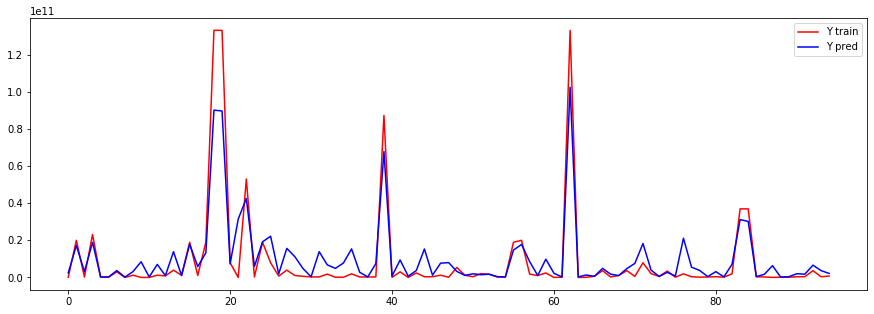

In [463]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData)), YData, 'r', label='Y train')
plt.plot(range(len(YData)), train_y_pred, 'b', label='Y pred')
plt.legend()

YData

In [397]:
# Predicted values for x
y_pred_fcst = regressor.predict(XData_fcst)
#y_pred_fcst

In [398]:
# forecast MSE and RMSE
from sklearn import metrics
RF_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst))
print('MSE:',RF_MSE,'RMSE:',RMSE)

MSE: 3.00700531492e+20 RMSE: 17340718886.251514


In [399]:
# forecast R^2
from sklearn.metrics import r2_score
fore_RF_r2=r2_score(YData_fcst , y_pred_fcst)
fore_RF_r2

0.4836887987076023

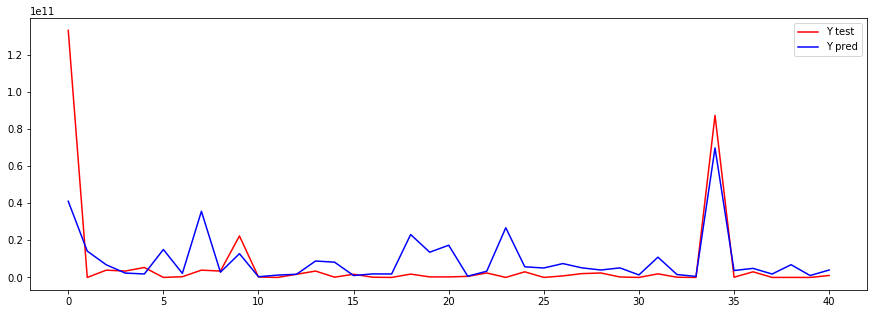

In [400]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

##### Training R^2 is still better than Forecasting  R^2, there may be the problem of overfitting.

### 2.1.1 K-fold Random Forest

In [402]:
train_index

In [471]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import metrics
import random

RF_r2=[]
RF_MSE=[]
RF_RMSE=[]
fore_RF_r2=[]
for train_index, test_index in kf.split(X, y):
    random.shuffle(train_index)
    random.shuffle(test_index)

    XTrain=X.iloc[train_index]
    yTrain=y.iloc[train_index]
    XTest=X.iloc[test_index]
    yTest=y.iloc[test_index]
    # Train
    regressor = RandomForestRegressor(n_estimators=100)
    regressor.fit(XTrain, yTrain)
    train_y_pred = regressor.predict(XTrain)
    RF_r2.append(r2_score(yTrain , train_y_pred))
    # Forecast
    y_pred_fcst = regressor.predict(XTest)
    RF_MSE.append(metrics.mean_squared_error(yTest, y_pred_fcst))
    RF_RMSE.append(np.sqrt(metrics.mean_squared_error(yTest, y_pred_fcst)))
    fore_RF_r2.append(r2_score(yTest , y_pred_fcst))
    
    
    

mean_RF_r2=np.mean(RF_r2)
mean_RF_MSE=np.mean(RF_MSE)
mean_RF_RMSE=np.mean(RF_RMSE)
mean_RF_fore_r2=np.mean(fore_RF_r2)
print('mean_RF_r2:',mean_RF_r2,'mean_RF_MSE:',mean_RF_MSE,'mean_RF_RMSE:',mean_RF_RMSE,'mean_RF_fore_r2:',mean_RF_fore_r2)




mean_RF_r2: 0.9060480305327705 mean_RF_MSE: 7.153756599048358e+20 mean_RF_RMSE: 22134731060.769264 mean_RF_fore_r2: -14.924543988067052


In [472]:
Test =Merge5.iloc[test_index]
# d={'Predicted':[y_pred_fcst]}
Test['Predicted']=y_pred_fcst
Test_simple=Test[['NAME','current damage($ 2020)','winds(MPH)','Year','avg_GDPMER','Predicted']]
Test_simple=Test_simple.sort_index()

C:\Users\kwonk\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


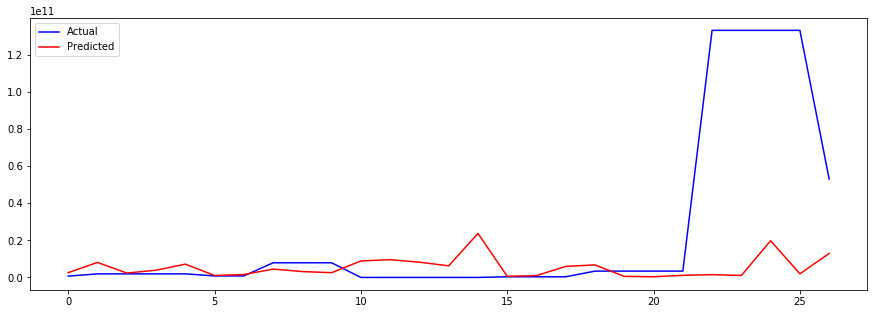

In [473]:
plt.figure(figsize=(15,5))
plt.plot(range(len(Test_simple)), Test_simple['current damage($ 2020)'], 'b', label='Actual')
plt.plot(range(len(Test_simple)), Test_simple['Predicted'], 'r', label='Predicted')
plt.legend()

### 2.2 Linear Regression(re-assign)

In [ ]:
from sklearn.linear_model import LinearRegression 
linreg = LinearRegression()
linreg.fit(XData, YData)
train_y_pred = linreg.predict(XData)
# validation dataset R^2
score=cross_val_score(regressor, XData, YData, cv=10,scoring='r2')
score 

In [ ]:
# train R^2
from sklearn.metrics import r2_score
LR_r2=r2_score(YData , train_y_pred)
LR_r2

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData)), YData, 'r', label='Y train')
plt.plot(range(len(YData)), train_y_pred, 'b', label='Y pred')
plt.legend()

In [ ]:
# Predicted values for x
y_pred_fcst = linreg.predict(XData_fcst)
#y_pred_fcst

In [ ]:
# forecast MSE, RMSE
from sklearn import metrics
LR_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst))
print('MSE:',LR_MSE,'RMSE:',RMSE)

In [ ]:
# forecast R^2
from sklearn.metrics import r2_score
fore_LR_r2=r2_score(YData_fcst , y_pred_fcst)
fore_LR_r2

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

### 2.2.2 K-fold Linear Reg

In [ ]:
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import r2_score
from sklearn import metrics

LR_r2=[]
LR_MSE=[]
LR_RMSE=[]
fore_LR_r2=[]
for train_index, test_index in kf.split(X, y):
    XTrain=X.iloc[train_index]
    yTrain=y.iloc[train_index]
    XTest=X.iloc[test_index]
    yTest=y.iloc[test_index]
    # Train
    regressor = LinearRegression()
    regressor.fit(XTrain, yTrain)
    train_y_pred = regressor.predict(XTrain)
    LR_r2.append(r2_score(yTrain , train_y_pred))
    # Forecast
    y_pred_fcst = regressor.predict(XTest)
    LR_MSE.append(metrics.mean_squared_error(yTest, y_pred_fcst))
    LR_RMSE.append(np.sqrt(metrics.mean_squared_error(yTest, y_pred_fcst)))
    fore_LR_r2.append(r2_score(yTest , y_pred_fcst))
    

mean_LR_r2=np.mean(LR_r2)
mean_LR_MSE=np.mean(LR_MSE)
mean_LR_RMSE=np.mean(LR_RMSE)
mean_LR_fore_r2=np.mean(fore_LR_r2)
print('mean_LR_r2:',mean_LR_r2,'mean_LR_MSE:',mean_LR_MSE,'mean_LR_RMSE:',mean_LR_RMSE,'mean_LR_fore_r2:',mean_LR_fore_r2)

### 2.3 Gradient Boosting Regressor

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0, loss='ls')
est.fit(XData,YData)
est_train_pred_y=est.predict(XData)
mean_squared_error(YData,est_train_pred_y)   

In [ ]:
# validation dataset R^2
score=cross_val_score(regressor, XData, YData, cv=10,scoring='r2')

# train R^2
from sklearn.metrics import r2_score
GB_r2=r2_score(YData , est_train_pred_y)

print(score,GB_r2)

In [ ]:
import statistics
statistics.mean(score)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData)), YData, 'r', label='Y train')
plt.plot(range(len(YData)), est_train_pred_y, 'b', label='Y pred')
plt.legend()

In [ ]:
# Predicted values for x
y_pred_fcst = est.predict(XData_fcst)
#y_pred_fcst

In [ ]:
# forecast MSE, RMSE
from sklearn import metrics
GB_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst))
print('MSE:',GB_MSE,'RMSE:',RMSE)

In [ ]:
# forecast R^2
from sklearn.metrics import r2_score
fore_GB_r2=r2_score(YData_fcst , y_pred_fcst)
fore_GB_r2

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

In [ ]:
# find the best learning_rate
from sklearn.metrics import r2_score
for i in np.arange(0.1,1.1,0.1): 
    est = GradientBoostingRegressor(n_estimators=100, learning_rate=i,max_depth=1, random_state=0, loss='ls')
    est.fit(XData,YData)
    # val
    score=cross_val_score(regressor, XData, YData, cv=10,scoring='r2')
    mean_score=statistics.mean(score)
    # train
    est_train_pred_y=est.predict(XData)
    # train R^2
    r2_train=r2_score(YData,est_train_pred_y)
    # forecast
    y_pred_fcst = est.predict(XData_fcst)
    # forecast R^2
    r2_forecast_score=r2_score(YData_fcst , y_pred_fcst)
    print('i:',i,'val_R^2:',mean_score,'train R^2:',r2_train,'test R^2:',r2_forecast_score)
# then, we will choose from sklearn.metrics import r2_score =1.0

### 2.3.2 K-fold Gradient Boosting Reg

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn import metrics

for i in np.arange(0.1,1.1,0.1):
    regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=i,max_depth=1, random_state=0, loss='ls')
    GB_r2=[]
    GB_MSE=[]
    GB_RMSE=[]
    fore_GB_r2=[]
    for train_index, test_index in kf.split(X, y):
        XTrain=X.iloc[train_index]
        yTrain=y.iloc[train_index]
        XTest=X.iloc[test_index]
        yTest=y.iloc[test_index]
        # Train
        regressor.fit(XTrain, yTrain)
        train_y_pred = regressor.predict(XTrain)
        GB_r2.append(r2_score(yTrain , train_y_pred))
        # Forecast
        y_pred_fcst = regressor.predict(XTest)
        GB_MSE.append(metrics.mean_squared_error(yTest, y_pred_fcst))
        GB_RMSE.append(np.sqrt(metrics.mean_squared_error(yTest, y_pred_fcst)))
        fore_GB_r2.append(r2_score(yTest , y_pred_fcst))
    mean_GB_r2=np.mean(GB_r2)
    mean_GB_MSE=np.mean(GB_MSE)
    mean_GB_RMSE=np.mean(GB_RMSE)
    mean_GB_fore_r2=np.mean(fore_GB_r2)
    print('i:',i,'mean_GB_r2:',mean_GB_r2,'mean_GB_MSE:',mean_GB_MSE,'mean_GB_RMSE:',mean_GB_RMSE,'mean_GB_fore_r2:',mean_GB_fore_r2)
# Then, I will set learning_rate=0.8

In [ ]:
regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.8,max_depth=1, random_state=0, loss='ls')
GB_r2=[]
GB_MSE=[]
GB_RMSE=[]
fore_GB_r2=[]
for train_index, test_index in kf.split(X, y):
    XTrain=X.iloc[train_index]
    yTrain=y.iloc[train_index]
    XTest=X.iloc[test_index]
    yTest=y.iloc[test_index]
    # Train
    regressor.fit(XTrain, yTrain)
    train_y_pred = regressor.predict(XTrain)
    GB_r2.append(r2_score(yTrain , train_y_pred))
    # Forecast
    y_pred_fcst = regressor.predict(XTest)
    GB_MSE.append(metrics.mean_squared_error(yTest, y_pred_fcst))
    GB_RMSE.append(np.sqrt(metrics.mean_squared_error(yTest, y_pred_fcst)))
    fore_GB_r2.append(r2_score(yTest , y_pred_fcst))
mean_GB_r2=np.mean(GB_r2)
mean_GB_MSE=np.mean(GB_MSE)
mean_GB_RMSE=np.mean(GB_RMSE)
mean_GB_fore_r2=np.mean(fore_GB_r2)
print('i:',i,'mean_GB_r2:',mean_GB_r2,'mean_GB_MSE:',mean_GB_MSE,'mean_GB_RMSE:',mean_GB_RMSE,'mean_GB_fore_r2:',mean_GB_fore_r2)
# Then, I will set learning_rate=0.8

### 2.4 AdaBoostRegressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
adaReg = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate=1.0)
adaReg.fit(XData,YData)
ada_train_pred_y=adaReg.predict(XData)

In [ ]:
# validation dataset R^2
score=cross_val_score(adaReg, XData, YData, cv=10,scoring='r2')

# train R^2
from sklearn.metrics import r2_score
AB_r2=r2_score(YData , ada_train_pred_y)

print(score,AB_r2)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData)), YData, 'r', label='Y train')
plt.plot(range(len(YData)), ada_train_pred_y, 'b', label='Y pred')
plt.legend()

In [ ]:
# Predicted values for x
y_pred_fcst = adaReg.predict(XData_fcst)
#y_pred_fcst

In [ ]:
# forecast MSE, RMSE
from sklearn import metrics
AB_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst))
print('MSE:',AB_MSE,'RMSE:',RMSE)

In [ ]:
# forecast R^2
from sklearn.metrics import r2_score
fore_AB_r2=r2_score(YData_fcst , y_pred_fcst)
fore_AB_r2

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

In [ ]:
# find the best learning_rate
from sklearn.metrics import r2_score
for i in np.arange(0.1,1.1,0.1): 
    adaReg = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate=i)
    adaReg.fit(XData,YData)
    # train
    ada_train_pred_y=adaReg.predict(XData)
    # train R^2
    r2_train=r2_score(YData,ada_train_pred_y)
    # forecast
    y_pred_fcst = adaReg.predict(XData_fcst)
    # forecast R^2
    r2_forecast_score=r2_score(YData_fcst , y_pred_fcst)
    print('i:',i,'train R^2:',r2_train,'test R^2:',r2_forecast_score)
# then, we will choose from sklearn.metrics import r2_score =1.0

### 2.4.2 K-fold Ada Boosting Reg

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn import metrics

for i in np.arange(0.1,1.1,0.1):
    regressor = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate=i)
    AB_r2=[]
    AB_MSE=[]
    AB_RMSE=[]
    fore_AB_r2=[]
    for train_index, test_index in kf.split(X, y):
        XTrain=X.iloc[train_index]
        yTrain=y.iloc[train_index]
        XTest=X.iloc[test_index]
        yTest=y.iloc[test_index]
        # Train
        #regressor = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate=1.0)
        regressor.fit(XTrain, yTrain)
        train_y_pred = regressor.predict(XTrain)
        AB_r2.append(r2_score(yTrain , train_y_pred))
        # Forecast
        y_pred_fcst = regressor.predict(XTest)
        AB_MSE.append(metrics.mean_squared_error(yTest, y_pred_fcst))
        AB_RMSE.append(np.sqrt(metrics.mean_squared_error(yTest, y_pred_fcst)))
        fore_AB_r2.append(r2_score(yTest , y_pred_fcst))
    mean_AB_r2=np.mean(AB_r2)
    mean_AB_MSE=np.mean(AB_MSE)
    mean_AB_RMSE=np.mean(AB_RMSE)
    mean_AB_fore_r2=np.mean(fore_AB_r2)
    print('i:',i,'mean_AB_r2:',mean_AB_r2,'mean_AB_MSE:',mean_AB_MSE,'mean_AB_RMSE:',mean_AB_RMSE,'mean_AB_fore_r2:',mean_AB_fore_r2)
# Then, I will set learning_rate=0.8

In [ ]:

regressor = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate=0.8)
AB_r2=[]
AB_MSE=[]
AB_RMSE=[]
fore_AB_r2=[]
for train_index, test_index in kf.split(X, y):
    XTrain=X.iloc[train_index]
    yTrain=y.iloc[train_index]
    XTest=X.iloc[test_index]
    yTest=y.iloc[test_index]
    # Train
    #regressor = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate=1.0)
    regressor.fit(XTrain, yTrain)
    train_y_pred = regressor.predict(XTrain)
    AB_r2.append(r2_score(yTrain , train_y_pred))
    # Forecast
    y_pred_fcst = regressor.predict(XTest)
    AB_MSE.append(metrics.mean_squared_error(yTest, y_pred_fcst))
    AB_RMSE.append(np.sqrt(metrics.mean_squared_error(yTest, y_pred_fcst)))
    fore_AB_r2.append(r2_score(yTest , y_pred_fcst))
mean_AB_r2=np.mean(AB_r2)
mean_AB_MSE=np.mean(AB_MSE)
mean_AB_RMSE=np.mean(AB_RMSE)
mean_AB_fore_r2=np.mean(fore_AB_r2)
print('i:',i,'mean_AB_r2:',mean_AB_r2,'mean_AB_MSE:',mean_AB_MSE,'mean_AB_RMSE:',mean_AB_RMSE,'mean_AB_fore_r2:',mean_AB_fore_r2)

### Part 3: Weighted Avg

In [ ]:
# simply weighted avg these methods predicted values
# RF regressor
RF_y_pred_fcst = regressor.predict(XData_fcst)
# linear reg
LR_y_pred_fcst = linreg.predict(XData_fcst)
# GDBT
GD_y_pred_fcst = est.predict(XData_fcst)
# ada reg
ada_y_pred_fcst = adaReg.predict(XData_fcst)
n=XData_fcst.shape[0]
weights=[0.2,0.1,0.2,0.5]
y_pred_fcst=[]
for i in range(n):
    y_pred_fcst.append(weights[0]*RF_y_pred_fcst[i]+weights[1]*LR_y_pred_fcst[i]+weights[2]*GD_y_pred_fcst[i]+weights[3]*ada_y_pred_fcst[i])

In [ ]:
y_pred_fcst2 = pd.Series(y_pred_fcst)

In [ ]:
# forecast MSE, RMSE
from sklearn import metrics
avg_MSE = metrics.mean_squared_error(YData_fcst, y_pred_fcst2)
RMSE = np.sqrt(metrics.mean_squared_error(YData_fcst, y_pred_fcst2))
print('MSE:',avg_MSE,'RMSE:',RMSE)

In [ ]:
# forecast R^2
from sklearn.metrics import r2_score
fore_avg_r2=r2_score(YData_fcst , y_pred_fcst2)
fore_avg_r2

In [ ]:
# forecast
plt.figure(figsize=(15,5))
plt.plot(range(len(YData_fcst)), YData_fcst, 'r', label='Y test')
plt.plot(range(len(YData_fcst)), y_pred_fcst, 'b', label='Y pred')
plt.legend()

### 3.1 K-fold weighted avg

In [ ]:
avg_r2=[]
avg_MSE=[]
avg_RMSE=[]
fore_avg_r2=[]
weights=[0.2,0.1,0.2,0.5]
for train_index, test_index in kf.split(X, y):
    XTrain=X.iloc[train_index]
    yTrain=y.iloc[train_index]
    XTest=X.iloc[test_index]
    yTest=y.iloc[test_index]
    # Train
    RFreg = RandomForestRegressor(n_estimators=100)
    LRreg =LinearRegression()
    GBreg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.8,max_depth=1, random_state=0, loss='ls')
    ABreg = AdaBoostRegressor(random_state=0, n_estimators=100,learning_rate=0.8)
    
    RFreg.fit(XTrain, yTrain)
    LRreg.fit(XTrain, yTrain)
    GBreg.fit(XTrain, yTrain)
    ABreg.fit(XTrain, yTrain)
    
    RF_train_y_pred = RFreg.predict(XTrain)
    LR_train_y_pred = LRreg.predict(XTrain)
    GB_train_y_pred = GBreg.predict(XTrain)
    AB_train_y_pred = ABreg.predict(XTrain)
    
    avg_train_y_pred=weights[0]*RF_train_y_pred+weights[1]*LR_train_y_pred+weights[2]*GB_train_y_pred+weights[3]*AB_train_y_pred
    
    avg_r2.append(r2_score(yTrain , avg_train_y_pred))
    
    # Forecast
    RF_y_pred_fcst = RFreg.predict(XTest)
    LR_y_pred_fcst = LRreg.predict(XTest)
    GB_y_pred_fcst = GBreg.predict(XTest)
    AB_y_pred_fcst = ABreg.predict(XTest)
    
    avg_y_pred_fcst=weights[0]*RF_y_pred_fcst+weights[1]*LR_y_pred_fcst+weights[2]*GB_y_pred_fcst+weights[3]*AB_y_pred_fcst
    
    avg_MSE.append(metrics.mean_squared_error(yTest, avg_y_pred_fcst))
    avg_RMSE.append(np.sqrt(metrics.mean_squared_error(yTest, avg_y_pred_fcst)))
    fore_avg_r2.append(r2_score(yTest , avg_y_pred_fcst))
mean_avg_r2=np.mean(avg_r2)
mean_avg_MSE=np.mean(avg_MSE)
mean_avg_RMSE=np.mean(avg_RMSE)
mean_avg_fore_r2=np.mean(fore_avg_r2)
print('mean_avg_r2:',mean_avg_r2,'mean_avg_MSE:',mean_avg_MSE,'mean_avg_RMSE:',mean_avg_RMSE,'mean_avg_fore_r2:',mean_avg_fore_r2)

### Part 4: Results

In [ ]:
from pandas import Series,DataFrame
import pandas as pd
results={ 'Method Name':['RandomForestRegressor','Linear Regrssion','Gradient Boosting Regressor','Ada Boost Regressor','Weigted Avg'],
         'train_R^2':[mean_RF_r2,mean_LR_r2,mean_GB_r2,mean_AB_r2,mean_avg_r2],
         'forecast_R^2':[mean_RF_fore_r2,mean_LR_fore_r2,mean_GB_fore_r2,mean_AB_fore_r2,mean_avg_fore_r2],
         'forecasr_MSE':[mean_RF_MSE,mean_LR_MSE,mean_GB_MSE,mean_AB_MSE,mean_avg_MSE],
         'forecasr_RMSE':[mean_RF_RMSE,mean_LR_RMSE,mean_GB_RMSE,mean_AB_MSE,mean_avg_RMSE],
}
resultsdf = DataFrame(results)
resultsdf